In [1]:
import torch 
import numpy as np
import collections
import time
import pickle 
from tqdm import tqdm

import sys
import os

os.environ['CUDA_VISIBLE_DEVICES']='4'

sys.path.append('engine/')
sys.path.append('funcs/')
sys.setrecursionlimit(10000)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

from Model import *
from eval_funcs import *
from plot_funcs import *
from utils import *
from csv_utils import *
from tifffile import *

data_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepstorm/datasets/'

In [2]:
train_images = imread(data_folder + 'SMLM_REAL/tubulin-3D/Tubulin-A647-3D-FULL.tif')
train_images = train_images[:,:train_images.shape[1]//4 * 4, :train_images.shape[2]//4 * 4]

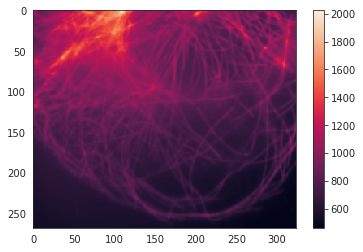

In [3]:
plt.imshow(train_images.mean(0))
plt.colorbar()

In [4]:
batch_size = 10
n_samples = 40
win_size = 40

rec_params = {}

rec_params['n_filters'] = 48
rec_params['factor'] = train_images.mean(0).max().astype(config.floatX)
rec_params['offset'] = train_images.mean().astype(config.floatX)
rec_params['global_context'] = False
rec_params['local_context'] = True
rec_params['bg_pred'] = False
rec_params['sig_pred'] = True

psf_params = {}
with open('psf_real.pkl', 'rb') as f:
    psf_fit = pickle.load(f)
psf_params = psf_fit['psf_params']
del(psf_params['beads_fit'])
psf_params['scale'] = 150.

ll_params = {}
ll_params['baseline'] = 398.6
ll_params['backg_max'] = 1000
ll_params['theta'] = gpu([2*100/5])

ll_params['p_act'] = 0.05
ll_params['p_lambda'] = 0.05
ll_params['surv_p'] = 0.5
ll_params['z_prior'] = [0.,0.5]
ll_params['prior_fac'] = 2
ll_params['min_int'] = 0.1

model = Model(rec_params, psf_params, ll_params)

model.train_mode = 'sl'

model.mgen.w_map = psf_fit['w_map']
model.fixed_psf = True
        
model.window_map = get_window_map(train_images,win_size, 20)
model.eval_csv = None
model.eval_imgs = train_images[1000:1010,:,:]

model.filename = 'test_real'

In [5]:
model.fit(train_images, batch_size=batch_size,n_samples=n_samples, win_size=win_size, max_iters=50000, learning_rate = 6e-4, print_freq=500, print_output=True)

Factor: 114.975 || Cost: 26.305 || Time Upd.: 219.9 || BatchNr.: 500
Factor: 160.573 || Cost: 9.305 || Time Upd.: 194.2 || BatchNr.: 1000
Factor: 173.318 || Cost: 2.359 || Time Upd.: 190.8 || BatchNr.: 1500
Factor: 173.313 || Cost: 0.631 || Time Upd.: 233.0 || BatchNr.: 2000
Factor: 158.633 || Cost: -2.864 || Time Upd.: 192.4 || BatchNr.: 2500
Factor: 168.009 || Cost: -3.354 || Time Upd.: 199.4 || BatchNr.: 3000
Factor: 173.679 || Cost: -5.821 || Time Upd.: 191.8 || BatchNr.: 3500
Factor: 167.387 || Cost: -7.378 || Time Upd.: 206.0 || BatchNr.: 4000
Factor: 164.804 || Cost: -8.005 || Time Upd.: 184.6 || BatchNr.: 4500
Factor: 170.640 || Cost: -8.777 || Time Upd.: 200.2 || BatchNr.: 5000
Factor: 199.505 || Cost: -9.989 || Time Upd.: 189.2 || BatchNr.: 5500
Factor: 177.704 || Cost: -10.191 || Time Upd.: 193.0 || BatchNr.: 6000
Factor: 183.766 || Cost: -11.586 || Time Upd.: 230.9 || BatchNr.: 6500
Factor: 172.421 || Cost: -11.546 || Time Upd.: 191.1 || BatchNr.: 7000
Factor: 169.955 || Co

In [4]:
with open('test_real.pkl', 'rb') as f:
    model = pickle.load(f)

In [5]:
def get_preds(images):
    arr_infs = decode_func(model,images,25, use_tqdm=False, z_scale=-model.mgen.psf_pars['z_scale'], int_scale=model.mgen.psf_pars['scale'])
    nms_sampling(arr_infs, threshold=0.7,  batch_size=500)
    rescale(arr_infs, 50, sig_3d=False)
    preds_batch = array_to_list(arr_infs, wobble=model.wobble, start_img=start_img, start_n=start_n)    
    return preds_batch  

In [6]:
start_img=0
start_n=0
preds = []

n_imgs = len(train_images)
print(n_imgs)

for i in tqdm(range(int(np.ceil(n_imgs/25)))):

    images = train_images[i*25:(i+1)*25, 50:150, 50:150]
    preds += get_preds(images)
    start_img = preds[-1][1]
    start_n = preds[-1][0] 

  0%|          | 0/4508 [00:00<?, ?it/s]

112683


100%|██████████| 4508/4508 [19:17<00:00,  3.89it/s]


In [ ]:
write_csv(preds, 'real_preds.csv')   

In [7]:
filtered_preds = filt_preds(preds,70,is_3d=True)

In [10]:
img = create_3d_hist(filtered_preds, z_clip=[-600,600], pix_size=10, sigma=5, contrast_fac=2, clip_density=99)

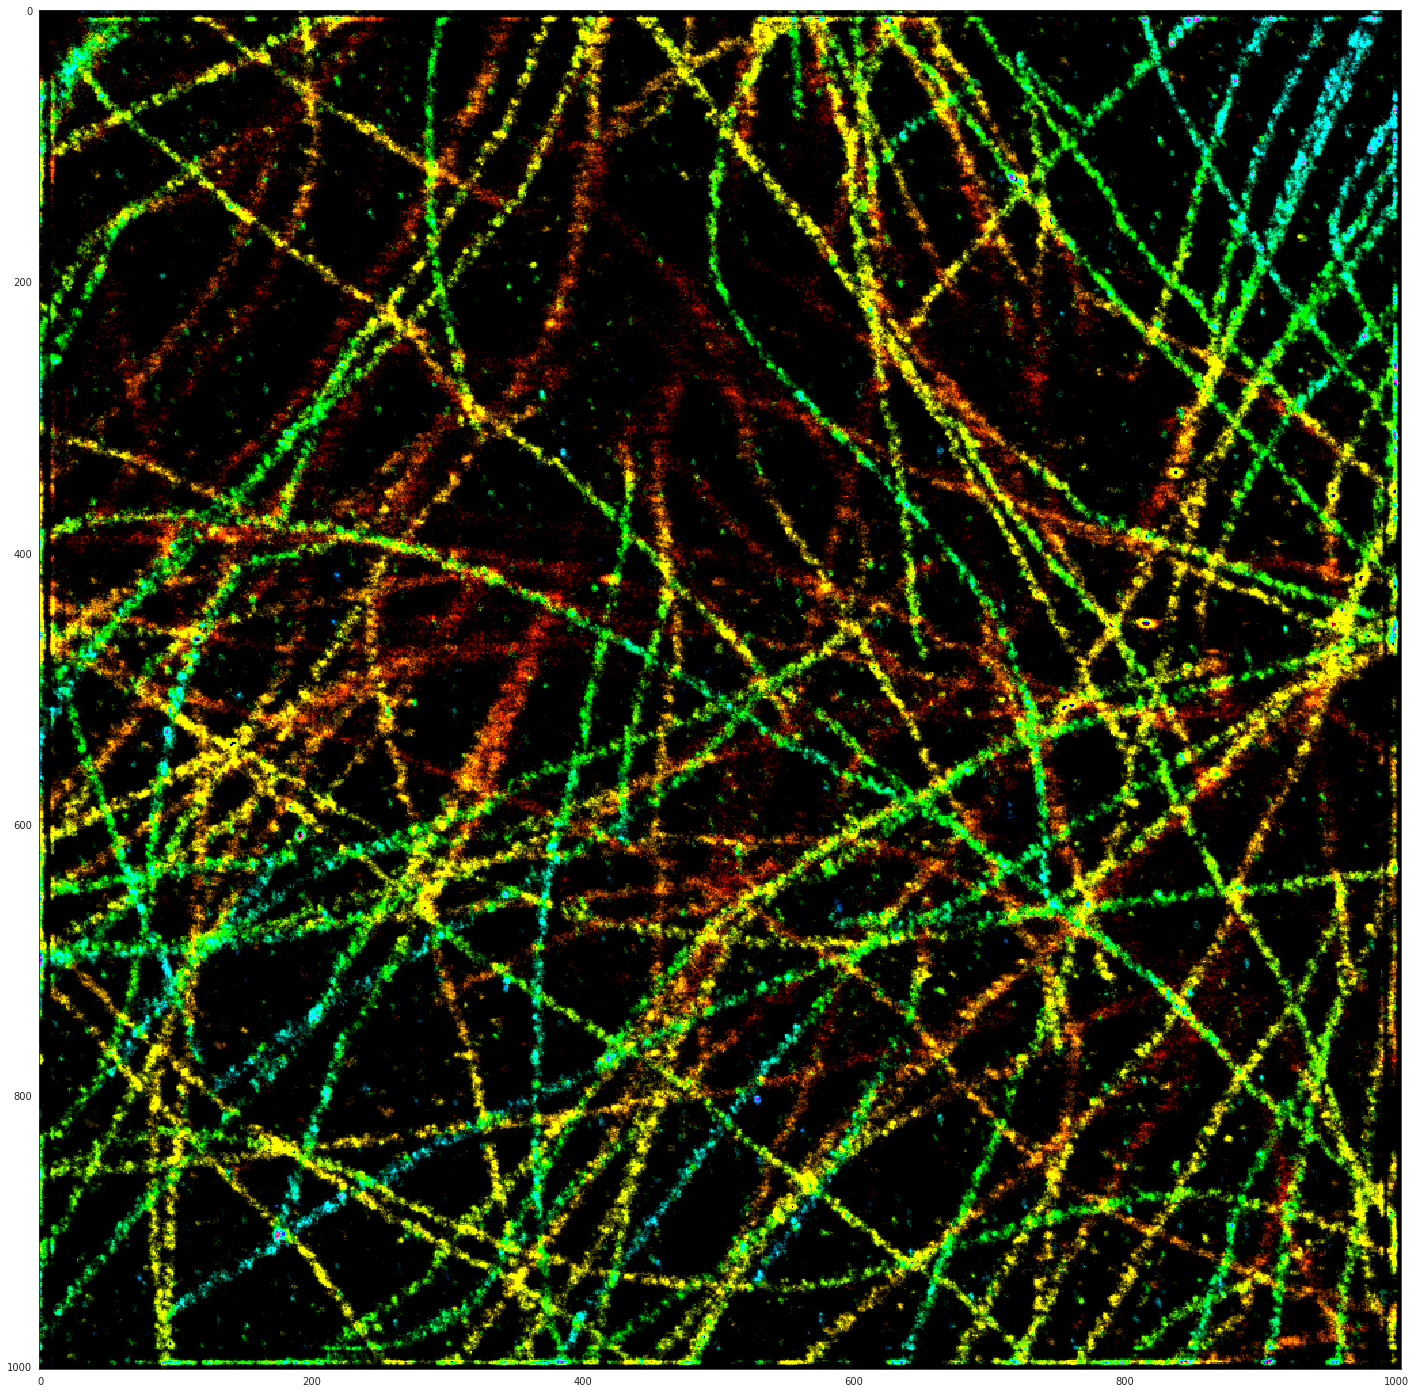

In [11]:
plt.figure(figsize=(25,25))
plt.imshow(img)